IMPORT LIBRARY

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Dataset Configuration

DATASET_DIR = "/content/drive/MyDrive/1. ASLP Alphabet"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2900 files belonging to 29 classes.
Using 2320 files for training.
Found 2900 files belonging to 29 classes.
Using 580 files for validation.


In [ ]:
#Class Labels

class_names = train_ds.class_names
print("Urutan Class names:", class_names)

Urutan Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
# 3. Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
# 4. build Arsitektur Model
#pakai mobilenetv2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# aktivasi softmax disini
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# 5. Compile & Training Tahap 1 (Training Top Layers)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

print("Starting Training Stage 1...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Starting Training Stage 1...
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1170s 16s/step - accuracy: 0.2311 - loss: 3.0781 - val_accuracy: 0.6397 - val_loss: 1.7317
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.7223 - loss: 0.8978 - val_accuracy: 0.8810 - val_loss: 0.9055
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.8623 - loss: 0.5013 - val_accuracy: 0.9241 - val_loss: 0.5148
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8890 - loss: 0.3673 - val_accuracy: 0.9448 - val_loss: 0.3339
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9105 - loss: 0.2971 - val_accuracy: 0.9517 - val_loss: 0.2417
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9367 - loss: 0.2189 - val_accuracy: 0.9690 - val_loss: 0.1732
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.9457 - loss: 0.2068 - val_accuracy: 0.9862 - val_loss: 0.1158
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9

In [ ]:
# 6. Fine-Tuning
base_model.trainable = True

# freeze
for layer in base_model.layers[:-30]:
    layer.trainable = False


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


early_stopping_fine = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

print("Starting Fine-Tuning...")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping_fine]
)

Starting Fine-Tuning...
Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.6447 - loss: 1.2256 - val_accuracy: 0.9845 - val_loss: 0.0732
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9388 - loss: 0.2006 - val_accuracy: 0.9431 - val_loss: 0.1737
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9655 - loss: 0.1043 - val_accuracy: 0.8534 - val_loss: 0.3881
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9742 - loss: 0.0671 - val_accuracy: 0.8793 - val_loss: 0.3376
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9883 - loss: 0.0356 - val_accuracy: 0.9138 - val_loss: 0.2397
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.9876 - loss: 0.0379 - val_accuracy: 0.9224 - val_loss: 0.2178
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.9923 - loss: 0.0255 - val_accuracy: 0.9362 - val_loss: 0.1822
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9940 -

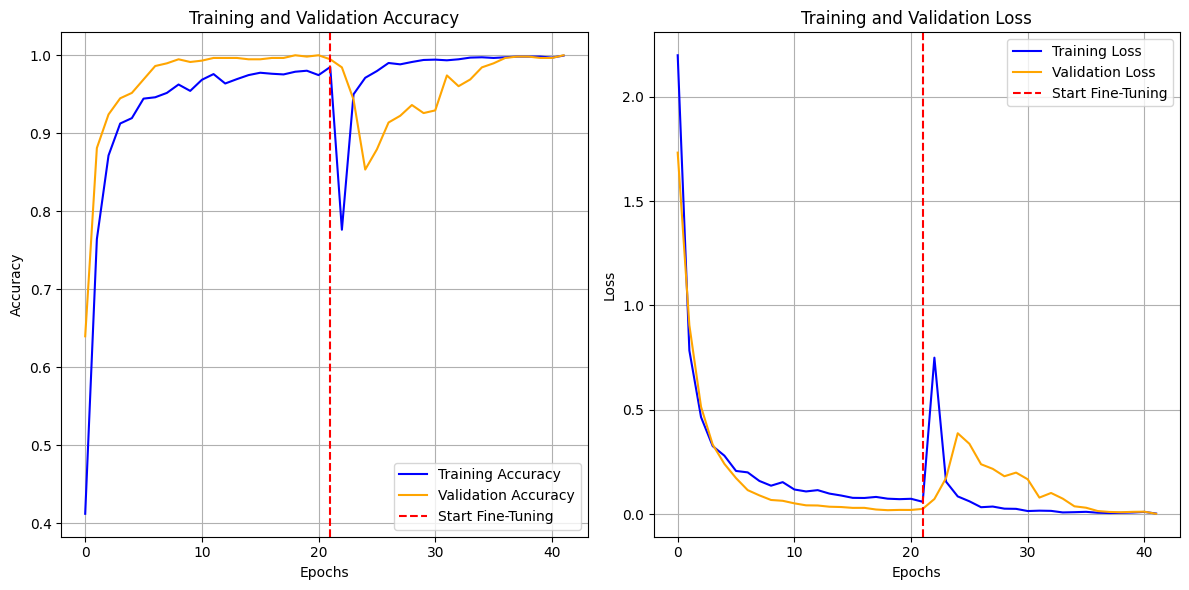

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

start_fine_tuning = len(history.history['accuracy'])


plt.figure(figsize=(12, 6))

# Subplot 1: Akurasi
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.axvline(x=start_fine_tuning-1, color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.axvline(x=start_fine_tuning-1, color='red', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/1. asl_mobilenet_final.keras")